# トークトリアル 4

# リガンドベーススクリーニング：化合物類似性

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Andrea Morger and Franziska Fritz

## このトークトリアルの目的

このトークトリアルでは、化合物をエンコード（記述子、フィンガープリント）し、比較（類似性評価）する様々なアプローチを取り扱います。さらに、バーチャルスクリーニングを実施します。バーチャルスクリーニングは、ChEMBLデータベースから取得し、リピンスキーのルールオブファイブでフィルタリングをかけた、EGFRに対して評価済みの化合物データセット（**トークトリアル 2**　参照）　に対して、EGFR阻害剤ゲフィチニブ（Gefitinib）との類似性検索を実施するという形で実施します。

## 学習の目標

### 理論

* 化合物類似性（Molecular similarity）
* 化合物記述子（Molecular descriptors）
* 化合物フィンガープリント（Molecular fingerprints）
  * 部分構造ベースのフィンガープリント（Substructure-based fingerprints）
  * MACCSフィンガープリント（MACCS fingerprints）
  * Morganフィンガープリント、サーキュラーフィンガープリント（Morgan fingerprints, circular fingerprints）
* 化合物類似性評価（Molecular similarity measures）
  * タニモト係数（Tanimoto coefficient）
  * Dice係数（Dice coefficient）
* バーチャルスクリーニング（Virtual screening）
  * 類似性検索（similarity search)によるバーチャルスクリーニング
  
### 実践

* 分子の読み込みと描画
* 化合物記述子の計算
  * 1D 化合物記述子：分子量
  * 2D 化合物記述子：MACCS ファインガープリント
  * 2D 化合物記述子：Morgan フィンガープリント
* 化合物類似性の計算
  * MACCS フィンガープリント：タニモト類似性とDice類似性
  * Morgan フィンガープリント：タニモト類似性とDice類似性
* 類似性検索によるバーチャルスクリーニング
  * データセットの全化合物に対する化合物クエリの比較
  * 類似度の分布
  * 最も類似した分子の描画
  * エンリッチメントプロットの作成

## レファレンス

* レビュー"Molecular similarity in medicinal chemistry" ([<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204](http://pubs.acs.org/doi/abs/10.1021/jm401411z))
* RDKitのMorganフィンガープリント ([RDKit tutorial on Morgan fingerprints](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints))
* ECFP - extended-connectivity fingerprints ([<i>J. Chem. Inf. Model.</i> (2010), <b>50</b>,742-754](https://pubs.acs.org/doi/abs/10.1021/ci100050t))
* ケミカルスペース
([<i>ACS Chem. Neurosci.</i> (2012), <b>19</b>, 649-57](https://www.ncbi.nlm.nih.gov/pubmed/23019491))
* RDKitの化合物記述子リスト ([RDKit documentation: Descriptors](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors))
* RDKitのフィンガープリントのリスト ([RDKit documentation: Fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints))
* エンリッチメントプロット([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h))

_____________________________________________________________________________________________________________________


## 理論

### 化合物類似性

化合物類似性は化学情報学（ケモインフォマティクス、chemical informatics）の中でよく知られており、頻繁に用いられる考え方です。化合物とその特性の比較はいろいろな用途で使用でき、望みの特性と生理活性をもつ新しい化合物を見つけるのに役立つかもしれません。

構造的に類似の化合物は類似の特性、そして類似の生理活性を示すという考え方は、類似性質原則（similar property principle、SPP）や構造活性相関（structure activity relationship、SAR）に表れています。この文脈において、バーチャルスクリーニングは、結合親和性のわかっている化合物セットがあれば、そのような化合物をさらに探すことができる、というアイデアに基づいています。

### 化合物記述子

類似度は適用範囲に応じて様々な方法で評価することができます(参考 <a href="http://pubs.acs.org/doi/abs/10.1021/jm401411z"><i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204</a>):

* **1D 化合物記述子**: 溶解度、logP、分子量、融点 etc.
    * グローバル記述子（Global descriptor）：分子全体を一つの値だけで表現する <br>
    * 通常、機械学習（machine learning、ML）を適用するには分子を特定するのに十分な特性とはならない
    * 機械学習のための化合物エンコーディングを改良するために２Dフィンガープリントに付け加えることができる
* **2D 化合物記述子**: 分子グラフ（Molecular graph）、経路（path）、フラグメント、原子環境（atom environment）
    * 分子の個々の部位の詳細な表現
    * 一つの分子に対して多数のフィンガープリントと呼ばれる特徴/ビット
    * 類似性検索と機械学習で非常によく使われる
* **3D 化合物記述子**: 形状（Shape）, 立体化学
    * 化学者は通常２次元表現で訓練されている　<br>
    * 化合物の自由度（flexibility、化合物の「正しい」配座はどれか？）のため、２次元表現と比べて頑健性が低い
* **生物学的類似性**
    * 生物学的フィンガープリント（例、個々のビットが異なるターゲット分子に対して評価された生理活性を表す）
    * 化合物構造からは独立
    * 実験データ（あるいは予測値）が必要

すでに **トークトリアル　2**　で、分子量やlogPといった1D　物理化学パラメーターを計算する方法を学びました。RDKitに実装されているそのような記述子は [RDKit documentation: Descriptors](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors)　で見つけることができます。

以降では、２D（あるいは３D）化合物記述子の定義に焦点を当てます。多くの場合、分子ごとに固有の（ユニークな）ものとなるので、これらの記述子はフィンガープリント（指紋）ともよばれます。

### 化合物フィンガープリント（Molecular fingerprints）

#### 部分構造に基づくフィンガープリント（Substructure-based fingerprints）

化合物フィンガープリントは化学的な特徴と分子の特徴をビット文字列（bitstring）やビットベクトル（bitvector）、配列（array）の形でエンコードします。各ビットは、事前に定義された分子の特徴あるいは環境に相当し、「１」はその特徴が存在していることを、「０」は存在していないことを示します。実装の仕方によっては、数え上げベース（count-baseｄ）となっていて、ある特定の特徴がいくつ存在しているかを数えるようになっていることに注意してください。

フィンガープリントのデザインには複数の方法があります。ここではよく使われる２Dフィンガープリントのとして、MACCSキーとMorganフィンガープリントの２種類を導入します。
 [RDKit documentation: Fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints)に記載されているように、RDKitではこの２つ以外にも多数のフィンガープリントを提供しています。

#### MACCS フィンガープリント（MACCS fingerprints）

Molecular ACCess System (MACCS) フィンガープリント、あるいはMACCS構造キーとも名付けられている手法は、あらかじめ定義された166個の構造フラグメントから構成されています。各位置は、ある特定の構造フラグメントあるいはキーが存在しているかいないかを問い合わせた（クエリ）結果を格納しています。それぞれのキーは創薬化学者によって経験的に定義されたもので、利用、解釈が容易です。([RDKit documentation: MACCS keys](http://rdkit.org/Python_Docs/rdkit.Chem.MACCSkeys-module.html)).

<img src="images/maccs_fp.png" align="above" alt="Image cannot be shown" width="250">
<div align="center"> Figure 2: MACCSフィンガープリントの図例(Andrea Morgerによる図)</div>

#### Morganフィンガープリントとサーキュラーフィンガープリント（Morgan fingerprints and circular fingerprints） 

この一連のフィンガープリントはMorganアルゴリズムに基づいています。ビットは分子の各原子の円形状の環境（circular environment）に相当しています。半径（radius）によって、環境として考慮にいれる近接の結合と原子の数を設定します。ビット文字列の長さを定義することもでき、より長いビット文字列を希望する長さに縮められます。従って、Morganフィンガープリントはある特定の数のビットには制限されません。Morganフィンガープリントに関してもっと知りたい場合は[RDKit documentation: Morgan fingerprints](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints)　を参照してください。Extended connectivity fingerprints　(ECFP)もよく使われるフィンガープリントで、Morganアルゴリズムのバリエーションから導かれています。さらなる情報は([<i>J. Chem. Inf. Model.</i> (2010), <b>50</b>,742-754](https://pubs.acs.org/doi/abs/10.1021/ci100050t))を参照してください。

<img src="images/morgan_fp.png" align="above" alt="Image cannot be shown" width="270">
<div align="center">Figure 3: Morganサーキュラーフィンガープリントの図例(Andrea Morgerによる図)</div>

### 化合物類似性評価

記述子/フィンガープリントの計算ができれば、それらを比較することで、二つの分子の間の類似度を評価することができます。化合物類似度は様々な類似度係数で定量化することができますが、よく使われる２つの指標はタニモト係数とDice係数です（Tanimoto and Dice index） ([<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204](http://pubs.acs.org/doi/abs/10.1021/jm401411z))。

#### タニモト係数（Tanimoto coefficient）

$$T _{c}(A,B) = \frac{c}{a+b-c}$$

a: 化合物Aに存在する特徴の数　<br>
b: 化合物Bに存在する特徴の数　 <br>
c: 化合物AとBで共有されている特徴の数

#### Dice係数（Dice coefficient）

$$D_{c}(A,B) = \frac{c}{\frac{1}{2}(a+b)}$$

a: 化合物Aに存在する特徴の数　<br>
b: 化合物Bに存在する特徴の数　 <br>
c: 化合物AとBで共有されている特徴の数

類似度評価は通常、それぞれのフィンガープリントの正の（１の）ビットの数と、両者が共通してもつ正のビットの数を考慮します。Dice類似度は通常タニモト類似度よりも大きな値を返し、それはそれぞれの分母の違いに由来します。:

$$\frac{c}{a+b-c} \leq \frac{c}{\frac{1}{2}(a+b)}$$


### バーチャルスクリーニング（Virtual screening） 

医薬品探索の初期段階における課題は、低分子（化合物）のセットを、有りうる巨大なケミカルスペースから、研究対象のターゲット分子に結合するポテンシャルのあるものに範囲を狭めることです。このケミカルスペースは非常に大きく、低分子化合物群は部分構造(chemical moiety)の10<sup>20</sup> の組み合わせにまでいたります ([<i>ACS Chem. Neurosci.</i> (2012), <b>19</b>, 649-57](https://www.ncbi.nlm.nih.gov/pubmed/23019491))　。

目的のターゲット分子に対するこれら低分子の活性を評価するハイスループットスクリーニング（HTS）実験は費用と時間が非常にかかるので、計算機に支援された（computer-aided）手法により、試験にかける低分子のリストをより絞り込む（focused list）ことが期待されています。このプロセスはバーチャル（ハイスループット）スクリーニングと呼ばれていて、研究対象のターゲット分子に結合する可能性の最も高い低分子を見つけるために、巨大な低分子ライブラリーをルールとパターンのどちらか、あるいは両方によってフィルタリングします。

#### 類似度検索を用いたバーチャルスクリーニング

バーチャルスクリーニングの簡単な方法として、既知の活性化合物（群）と新規な化合物セットを比較して、最も類似しているものを探すことが行われます。類似性質原則（similar property principle、SPP）に基づき、（例えば既知の阻害剤に）最も類似した化合物は類似の効果を有すると推測されます。類似性検索に必要となるものは次の通りです（上でも詳細に議論しています）。

* 化学/分子の特徴をエンコードした表現
* 特徴のポテンシャルの重み付け（オプション）
* 類似度評価

類似性検索はある特定のデータベースの全ての化合物と一つの化合物との間の類似度を計算することで実行することができます。データベースの化合物の類似度係数によるランク付けにより、最も類似度の高い分子が得られます。

#### エンリッチメントプロット（Enrichment plots）

エンリッチメントプロットはバーチャルスクリーニングの結果の妥当性を評価するために使われ、ランク付けされたリストの上位x%の中に含まれる活性化合物の比率を表します。すなわち、  

* データセット全体のうち、トップにランクした化合物の比率（x-axis）　 vs. 
* データセット全体のうち活性化合物（y-axis)の比率

<img src="images/enrichment_plot.png" align="above" alt="Image cannot be shown" width="270">
<div align="center">Figure 4: バーチャルスクリーニングの結果のエンリッチメントプロットの例</div>

## 実践

実践編の最初のパートでは、RDKitを使って化合物のエンコード（化合物フィンガープリント）をしたのち、上の理論編で議論したように、類似度（化合物類似性評価）を計算するため、それらの比較を実行します。

２番目のパートではこれらのエンコーディングと比較手法を使って類似度検索（バーチャルスクリーニング）を実施します。既知のEGFR阻害剤ゲフィチニブ（Gefitinib)をクエリとして使用し、EGFRに対して試験済みの化合物データセットの中から類似した化合物を検索します。このデータセットは **トークトリアル１**でChEMBLから抽出し、**トークトリアル2**でリピンスキーのルールオブファイブによりフィルタリングをおこなったものです。

### 化合物の読み込みと描画

まず、８個の化合物例を定義し描画します。後ほど、これらの分子をエンコードし比較します。SMILES形式の分子をRDKitのmolオブジェクトに変換し、RDKitの`Draw`関数で可視化します。

In [1]:
# 関連するPythonパッケージのimport
# 基本的な分子を取り扱う機能はモジュール　rdkti.Chem　にあります
from rdkit import Chem
# 描画関係
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

import math
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

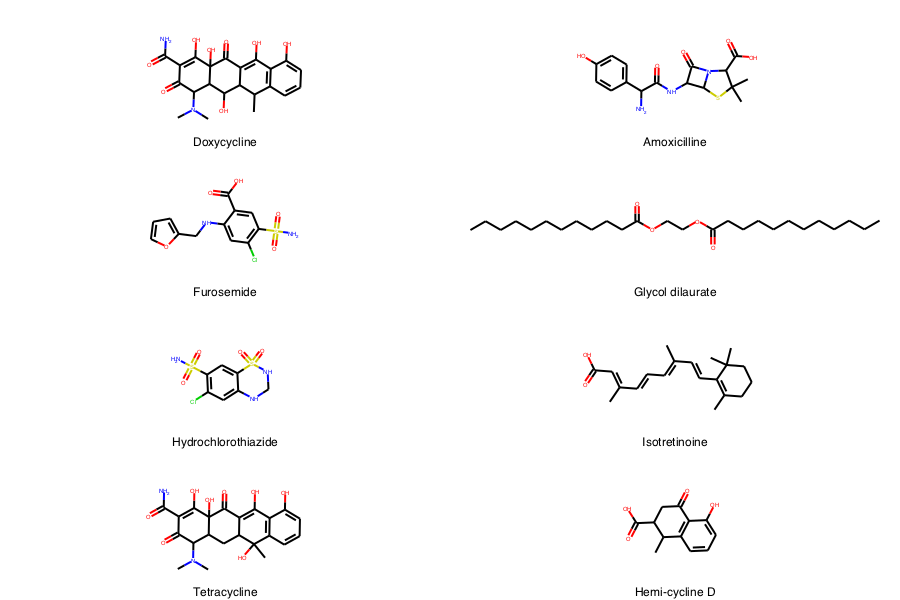

In [2]:
# SMILES形式の化合物
smiles1 = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O' # Doxycycline
smiles2 = 'CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C' # Amoxicilline
smiles3 = 'C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl' # Furosemide
smiles4 = 'CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC' # Glycol dilaurate
smiles5 = 'C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl' # Hydrochlorothiazide
smiles6 = 'CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C' # Isotretinoine
smiles7 = 'CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O' # Tetracycline
smiles8 = 'CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O' # Hemi-cycline D

# 化合物SMILESのリストを作成
smiles = [smiles1, smiles2, smiles3, smiles4, smiles5, smiles6, smiles7, smiles8]

# ROMolオブジェクトのリストを作成
mols = [Chem.MolFromSmiles(i) for i in smiles]

# 化合物名称のリストを作成
mol_names = ['Doxycycline', 'Amoxicilline', 'Furosemide', 'Glycol dilaurate',
             'Hydrochlorothiazide', 'Isotretinoine', 'Tetracycline', 'Hemi-cycline D']

# 化合物の描画
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(450,150), legends=mol_names)

### 化合物記述子の計算

化合物の比較を行うために1Dと２Dの化合物記述子を抽出、生成します。2D記述子については、あとで化合物の類似度の計算に使用するので、異なるタイプのフィンガープリントを生成します。

#### 1D 化合物記述子：分子量

例示構造の分子量を計算します。

In [3]:
# 化合物の分子量を計算
mol_weights = [Descriptors.MolWt(mol) for mol in mols]

視覚的に比較するために、類似の分子量の化合物構造を描画します。分子量は化合物の類似度にとって有用な記述子となるでしょうか？

In [4]:
# 結果を格納するデータフレームの生成
sim_mw_df = pd.DataFrame({'smiles': smiles, 'name': mol_names, 'mw': mol_weights, "Mol": mols})

# 分子量でソート
sim_mw_df.sort_values(['mw'], ascending=False, inplace=True)
sim_mw_df[["smiles", "name", "mw"]]

,smiles,name,mw
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,444.440
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,444.440
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,426.682
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,365.411
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,330.749
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoine,300.442
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,297.745
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,220.224


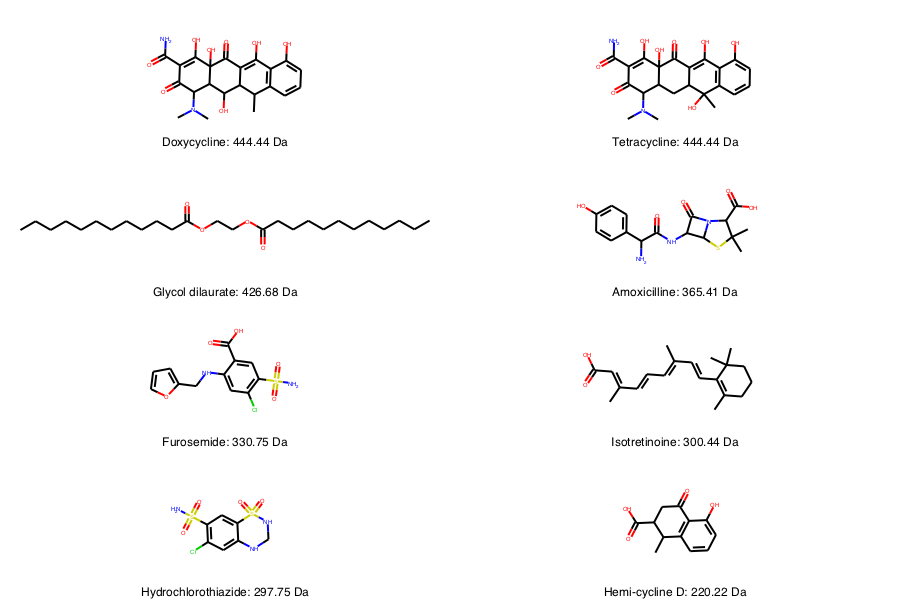

In [5]:
# 分子量とともに化合物を描画
Draw.MolsToGridImage(sim_mw_df["Mol"], 
                     legends=[i+': '+str(round(j, 2))+" Da" for i,j in zip(sim_mw_df["name"], sim_mw_df["mw"])],
                     molsPerRow=2, subImgSize=(450, 150))

見てわかるように類似の分子量を持つ化合物は類似の構造をもつことがあります（例　 Doxycycline/Tetracycline)。一方で、類似の数の原子を持ちながらも全く異なる原子の配置となっているものもあります（例　 Doxycycline/Glycol dilaurate あるいはHydrochlorothiazide/Isotretinoine)。

次に、より詳細な分子の特徴を説明するために、２D化合物記述子を見て見ましょう。

#### 2D 化合物記述子：MACCSフィンガープリント

MACCSフィンガープリントはRDKitを使って簡単に生成することができます。明示的なビットベクトル（explicit bitvector）は我々人間が読めるものではないので、さらにビット文字配列（bitstring）へと変換します。

In [6]:
# MACCSフィンガープリントの生成
maccs_fp1 = MACCSkeys.GenMACCSKeys(mols[0])  # Doxycycline
maccs_fp2 = MACCSkeys.GenMACCSKeys(mols[1])  # Amoxicilline
maccs_fp1

In [7]:
# フィンガープリントをビット文字配列としてプリント
maccs_fp1.ToBitString()

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

In [8]:
# 全化合物のMACCS fingerprintsを生成
maccs_fp_list = []
for i in range(len(mols)):
    maccs_fp_list.append(MACCSkeys.GenMACCSKeys(mols[i]))

#### 2D 化合物記述子：Morganフィンガープリント

RDKitを使ってMorganサーキュラーフィンガープリントも計算します。２つの異なる関数により、Morganフィンガープリントは整数（int）あるいはビット（bit）ベクトルとして計算することができます。

In [9]:
# Morganフィンガープリントを生成（int vector）、デフォルトでは半径２でベクトルの長さは2048
circ_fp1 = rdFingerprintGenerator.GetCountFPs(mols[:1])[0]
circ_fp1

In [10]:
# セットされた値をみてみます：
circ_fp1.GetNonzeroElements()

{45: 1,
 118: 1,
 140: 1,
 163: 1,
 276: 1,
 303: 1,
 309: 1,
 314: 2,
 371: 1,
 438: 1,
 525: 1,
 557: 1,
 650: 3,
 673: 1,
 699: 1,
 807: 6,
 824: 1,
 829: 1,
 881: 1,
 1009: 1,
 1019: 5,
 1027: 1,
 1039: 1,
 1057: 3,
 1060: 1,
 1061: 1,
 1070: 1,
 1082: 1,
 1088: 1,
 1119: 1,
 1154: 1,
 1163: 2,
 1171: 1,
 1257: 1,
 1296: 1,
 1309: 1,
 1341: 1,
 1380: 9,
 1389: 1,
 1457: 1,
 1471: 1,
 1487: 1,
 1582: 1,
 1602: 3,
 1607: 1,
 1630: 1,
 1747: 1,
 1750: 2,
 1831: 1,
 1833: 1,
 1857: 1,
 1873: 3,
 1917: 1,
 1932: 1,
 2000: 1,
 2029: 1}

In [11]:
# Morganフィンガープリントを(bit vectorとして）生成、デフォルトでは半径２でフィンガープリントの長さは2048
circ_b_fp1 = rdFingerprintGenerator.GetFPs(mols[:1])[0]
circ_b_fp1

In [12]:
# フィンガープリントをビット文字列としてプリント
circ_b_fp1.ToBitString()

'000000000000100000000000000000000000000000000000000010000000100000000000000000000000000000000000000000000000000000000000000000000000110000000000100010000000000000000000000000000000110011000000000000000000000000000000000000000000000010000000000000000000000010000000110000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000010000000000000000000000000000000110011001000000000000000000000000000100000000000000000000000000000000000000000000000000000001000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000011000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000

In [13]:
# 全化合物のMorganフィンガープリントを生成
circ_fp_list = rdFingerprintGenerator.GetFPs(mols)

### 化合物類似度の計算

次では、２つの類似度評価、すなわち**Tanimoto**と**Dice**を、２つのタイプのフィンガープリント、すなわち**MACCS**と**Morgan**フィンガープリントに適用します。

例：２つのMACCSフィンガープリントをタニモト類似度で比較

In [14]:
# ２つの化合物のタニモト係数を計算
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2)

0.5909090909090909

In [15]:
# 同じ化合物のタニモト係数を計算
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp1)

1.0

次に、クエリ化合物を我々の化合物リストと比較したいと思います。
そこで、RDKitの ```BulkTanimotoSimilarity```関数と```BulkDiceSimilarity```関数を使って、タニモトあるいはDice類似度の類似度評価に基づいて、クエリのフィンガープリントと、リストに格納されたフィンガープリントとの類似度を計算します。

類似度を計算したあとで、次の関数を使ってランク付けした化合物を描画したいと思います。：

In [16]:
def draw_ranked_molecules(sim_df_sorted, sorted_column):
    """
    （ソートした）データフレームの分子を描画する関数
    """
    # ラベルを定義：最初の分子はクエリ(Query)で、次の分子はランク１から始まる
    rank = ["#"+str(i)+": " for i in range(0, len(sim_df_sorted))]
    rank[0] = "Query: "

    # Doxycyclineと最も類似した化合物（Tanimoto　と　MACCS フィンガープリント)
    top_smiles = sim_df_sorted["smiles"].tolist()
    top_mols = [Chem.MolFromSmiles(i) for i in top_smiles]
    top_names = [i+j+" ("+str(round(k, 2))+")" for i, j, k in zip(rank, sim_df_sorted["name"].tolist(), 
                                                                  sim_df_sorted[sorted_column])]

    return Draw.MolsToGridImage(top_mols, legends=top_names, molsPerRow=2, subImgSize=(450, 150))

次に、タニモト/Dice類似度評価に基づいて、MACCS/Morganフィンガープリントの比較の全ての組み合わせを調べます。そこで、結果を要約するデータフレームを作成します。

In [17]:
# 結果を格納するデータフレームの生成
sim_df = pd.DataFrame({'smiles': smiles, 'name': mol_names})

#### MACCSフィンガープリント：タニモト類似度

In [18]:
# 類似度評価スコアをデータフレームに追加
sim_df['tanimoto_MACCS'] = DataStructs.BulkTanimotoSimilarity(maccs_fp1,maccs_fp_list)

In [19]:
# MACCSフィンガープリントのタニモト類似度で並べ替えたデータフレーム
sim_df_sorted_t_ma = sim_df.copy()
sim_df_sorted_t_ma.sort_values(['tanimoto_MACCS'], ascending=False, inplace=True)
sim_df_sorted_t_ma

,smiles,name,tanimoto_MACCS
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,1.000000
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,0.928571
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,0.590909
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,0.403509
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,0.321839
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,0.306818
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoine,0.288136
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,0.149254


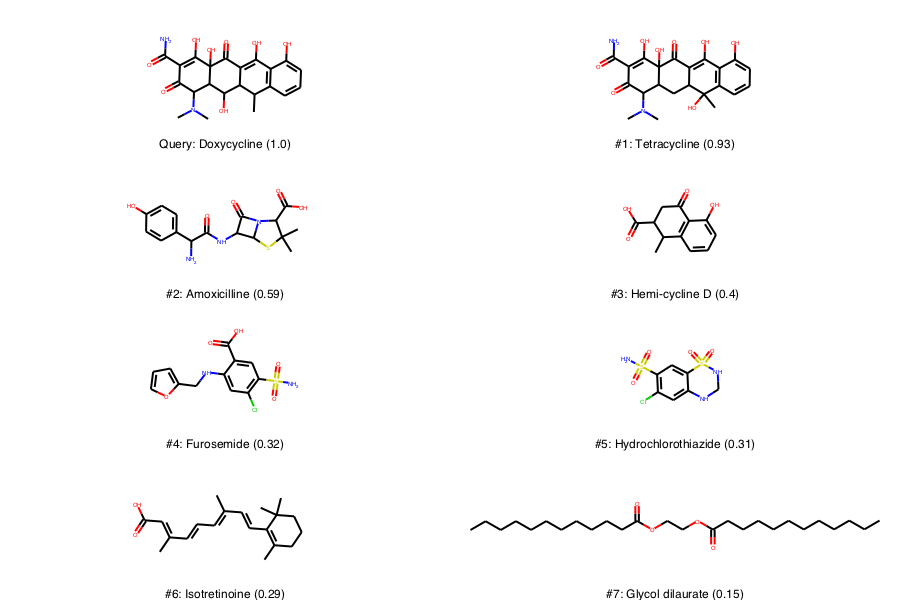

In [20]:
# MACCSフィンガープリントのタニモト類似度でランクした分子の描画
draw_ranked_molecules(sim_df_sorted_t_ma, "tanimoto_MACCS")

MACCSフィンガープリントを使用した場合、Tetracyclineは最も類似した分子（スコアが高い）で、ついでAmoxicillineでした。1D 化合物記述子の分子量とは対照的に、線形分子のGlucol dilaurateは類似していない（ランクが最も低い）と認識されました。

#### MACCSフィンガープリント：Dice類似度

In [21]:
# データフレームへの類似度スコアの追加
sim_df['dice_MACCS'] = DataStructs.BulkDiceSimilarity(maccs_fp1, maccs_fp_list)

In [22]:
# MACCSフィンガープリントのDice類似度でソートしたデータフレーム
sim_df_sorted_d_ma = sim_df.copy()
sim_df_sorted_d_ma.sort_values(['dice_MACCS'], ascending=False, inplace=True)
sim_df_sorted_d_ma

,smiles,name,tanimoto_MACCS,dice_MACCS
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,1.000000,1.000000
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,0.928571,0.962963
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,0.590909,0.742857
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,0.403509,0.575000
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,0.321839,0.486957
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,0.306818,0.469565
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoine,0.288136,0.447368
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,0.149254,0.259740


定義より、タニモトとDice類似度評価は同じランキング結果になりますが、Dice類似度の値の方が大きくなります（タニモトとDiceを求める式はこのトークトリアルの理論編を参照してください）。

#### Morganフィンガープリント：タニモト類似度

In [23]:
# データフレームへの類似度スコアの追加
sim_df['tanimoto_morgan'] = DataStructs.BulkTanimotoSimilarity(circ_b_fp1, circ_fp_list)
sim_df['dice_morgan'] = DataStructs.BulkDiceSimilarity(circ_b_fp1, circ_fp_list)

In [24]:
# Morganフィンガープリントのタニモト類似度で並べ替えたデータフレーム
sim_df_sorted_t_mo = sim_df.copy()
sim_df_sorted_t_mo.sort_values(['tanimoto_morgan'], ascending=False, inplace=True)
sim_df_sorted_t_mo

,smiles,name,tanimoto_MACCS,dice_MACCS,tanimoto_morgan,dice_morgan
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,1.000000,1.000000,1.000000,1.000000
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,0.928571,0.962963,0.616279,0.762590
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,0.403509,0.575000,0.345679,0.513761
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,0.590909,0.742857,0.262136,0.415385
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,0.321839,0.486957,0.141509,0.247934
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoine,0.288136,0.447368,0.121495,0.216667
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,0.306818,0.469565,0.108911,0.196429
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,0.149254,0.259740,0.084906,0.156522


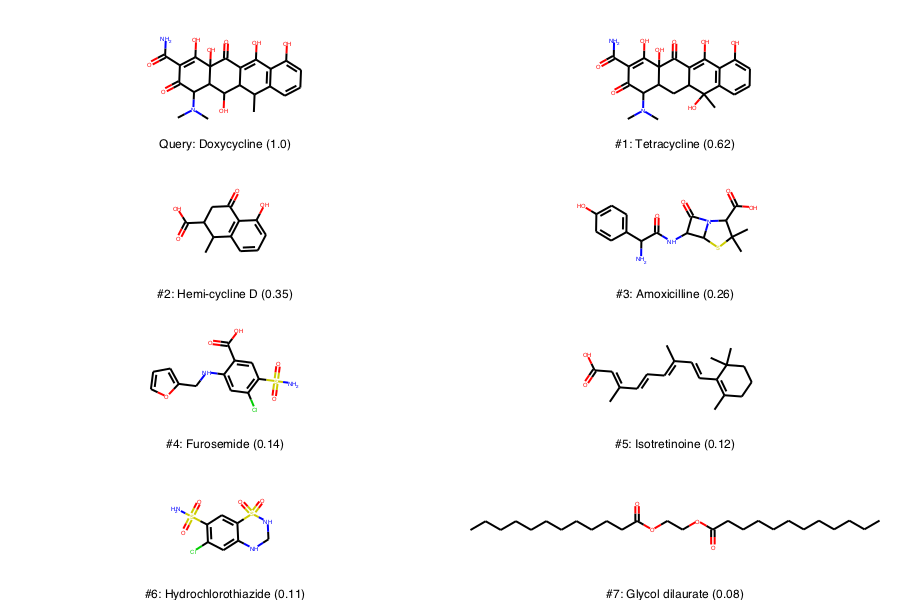

In [25]:
# Morganフィンガープリントのタニモト類似度による化合物ランキングの描画
draw_ranked_molecules(sim_df_sorted_t_mo, "tanimoto_morgan")

MACCSとMorganの類似度をタニモト（Morgan）　vs タニモト（MACCS）でプロットし比較します。

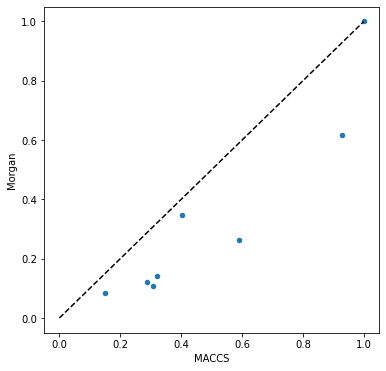

In [30]:
fig, axes = plt.subplots(figsize=(6,6), nrows=1, ncols=1)
sim_df_sorted_t_mo.plot('tanimoto_MACCS','tanimoto_morgan',kind='scatter',ax=axes)
plt.plot([0,1],[0,1],'k--')
axes.set_xlabel("MACCS")
axes.set_ylabel("Morgan")
plt.show()

異なるフィンガープリント（ここでは、MACCSフィンガープリントとMorganフィンガープリント）を用いると、異なる類似度の値（ここでは、タニモト係数）となり、ここで示したように、潜在的には化合物類似度のランキングが異なるものとなります。

MorganフィンガープリントはDoxycyclineに対してTetracyclineを（スコアはより低かったでしたが）最も類似した化合物として認識し、Glycol dilaurateを最も似ていない化合物として認識しました。一方で、２番目にランク付されたのはHemi-cycline Dでした。この化合物はサイクリン系化合物の部分構造で、Morganフィンガープリントのアルゴリズムが原子の環境に基づくものであることがその理由であるかもしれません（一方で、MACCSフィンガープリントは特定の特徴の出現頻度を求めるものとなっています）。

### 類似度検索を使ったバーチャルスクリーニング

フィンガープリントと類似度の計算方法を学んだので、この知識を化合物セット全体からのクエリ化合物の類似度検索に応用することができます。

既知のEGFR阻害剤ゲフィチニブ（Gefitinib)をクエリとして使用し、EGFRに対して試験済みの化合物データセットの中から類似した化合物を検索します。このデータセットは **トークトリアル１**でChEMBLから抽出し、**トークトリアル2**でリピンスキーのルールオブファイブによりフィルタリングをおこなったものです。

#### クエリ化合物をデータセットの全化合物と比較

**トークトリアル2**で取得したChEMBLデータベースから取り出したEGFRに対して評価済みのフィルタリングされた化合物を含むcsvファイルから化合物を読み込みます。１つのクエリ化合物（ここではゲフィチニブ）を使って、類似の化合物をデータセットの中から探し出します。

In [26]:
# SMILES形式の化合物を含むcsvファイルからデータを読み込む
filtered_df = pd.read_csv('../data/T2/EGFR_compounds_lipinski.csv', delimiter=';', usecols=['molecule_chembl_id', 'smiles', 'pIC50'])
filtered_df.head() 

,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910


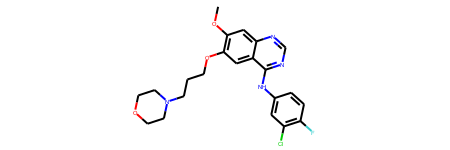

In [27]:
# クエリ化合物のSMILESからMolオブジェクトを生成
query = Chem.MolFromSmiles('COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1');  # Gefitinib, Iressa
query

In [28]:
# クエリ化合物のMACCSフィンガープリントとMorganフィンガープリントを生成
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circ_fp_query = rdFingerprintGenerator.GetCountFPs([query])[0]

In [29]:
# ファイルの全化合物のMACCSフィンガープリントとMorganフィンガープリントを生成
ms = [Chem.MolFromSmiles(i) for i in filtered_df.smiles]
circ_fp_list = rdFingerprintGenerator.GetCountFPs(ms)
maccs_fp_list = [MACCSkeys.GenMACCSKeys(m) for m in ms]

In [30]:
# クエリ化合物（Gefitinib）とファイルの全化合物のタニモト類似性を計算（MACCS、Morgan）
tanimoto_maccs = DataStructs.BulkTanimotoSimilarity(maccs_fp_query,maccs_fp_list)
tanimoto_circ = DataStructs.BulkTanimotoSimilarity(circ_fp_query,circ_fp_list)

In [31]:
# クエリ化合物（Gefitinib）とファイルの全化合物のDice類似性を計算（MACCS、Morgan）
dice_maccs = DataStructs.BulkDiceSimilarity(maccs_fp_query,maccs_fp_list)
dice_circ = DataStructs.BulkDiceSimilarity(circ_fp_query,circ_fp_list)

In [32]:
# ChEMBL IDとSMILES、Gefitinibに対する化合物のタニモト類似性のテーブルを作成
similarity_df = pd.DataFrame({'ChEMBL_ID':filtered_df.molecule_chembl_id,
                              'bioactivity':filtered_df.pIC50,
                              'tanimoto_MACCS': tanimoto_maccs, 
                              'tanimoto_morgan': tanimoto_circ, 
                              'dice_MACCS': dice_maccs,
                              'dice_morgan': dice_circ,
                              'smiles': filtered_df.smiles,})

In [33]:
# データフレームを表示
similarity_df.head()

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles
0,CHEMBL63786,11.522879,0.409836,0.324786,0.581395,0.490323,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1
1,CHEMBL53711,11.221849,0.484375,0.327434,0.652632,0.493333,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1
2,CHEMBL35820,11.221849,0.666667,0.445455,0.800000,0.616352,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC
3,CHEMBL53753,11.096910,0.428571,0.333333,0.600000,0.500000,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1
4,CHEMBL66031,11.096910,0.384615,0.345133,0.555556,0.513158,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1


#### 類似性評価の値の分布

理論編で述べたように、同じフィンガープリント（例　 MACCSフィンガープリント）について比較すれば、タニモト類似度の値はDIce類似度の値よりも小さくなります。また、２つの異なるフィンガープリント（例　MACCSフィンガープリントとMorganフィンガープリント）を比較すると、類似性評価の値（例　タニモト類似度）は変化します。

ヒストグラムをプロットすることで分布を見ることができます。

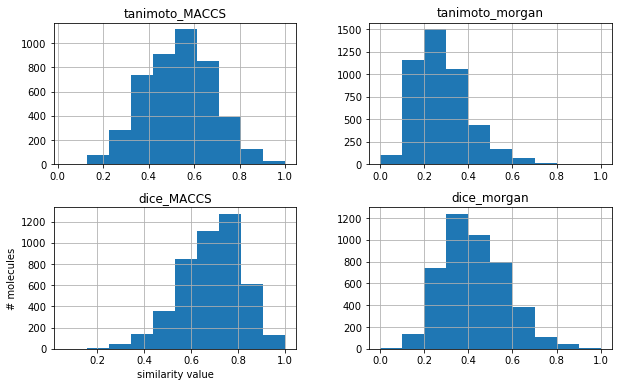

In [34]:
# MACCSフィンガープリントのタニモト類似度の分布をプロット
%matplotlib inline
fig, axes = plt.subplots(figsize=(10,6), nrows=2, ncols=2)
similarity_df.hist(["tanimoto_MACCS"], ax=axes[0,0])
similarity_df.hist(["tanimoto_morgan"], ax=axes[0,1])
similarity_df.hist(["dice_MACCS"], ax=axes[1,0])
similarity_df.hist(["dice_morgan"], ax=axes[1,1])
axes[1,0].set_xlabel("similarity value")
axes[1,0].set_ylabel("# molecules")
plt.show()

ここでも類似度を比較します。今回は直接、２つのフィンガープリントに関するタニモト類似度とDice類似度を比較します。

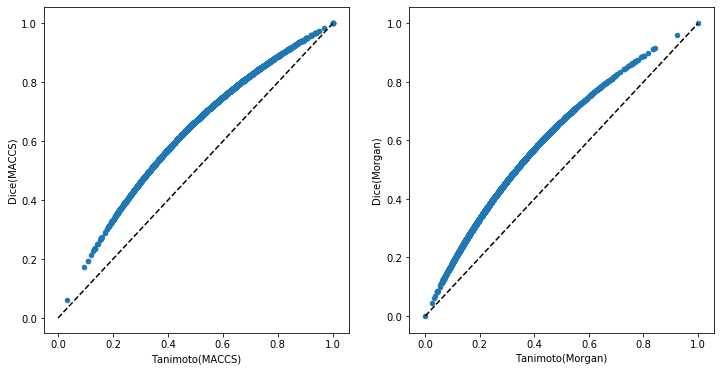

In [35]:
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

similarity_df.plot('tanimoto_MACCS','dice_MACCS',kind='scatter',ax=axes[0])
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel("Tanimoto(MACCS)")
axes[0].set_ylabel("Dice(MACCS)")

similarity_df.plot('tanimoto_morgan','dice_morgan',kind='scatter',ax=axes[1])
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel("Tanimoto(Morgan)")
axes[1].set_ylabel("Dice(Morgan)")

plt.show()

類似度分布は類似度を解釈するのに重要です（例　MACCSフィンガープリントとMorganフィンガープリント、タニモト類似度とDice類似度について値0.6は異なる評価を与えられる必要があります）

次では、Morganフィンガープリントに基づき、タニモト類似度で最もよく似た化合物を描画します。

#### 最も類似の化合物を描画

私たちの作成したランキングにおいて最も類似した化合物との比較として、ゲフィチニブ（Gefitinib）の構造を視覚的に調べます。生理活性の情報（**トークトリアル1**でChEMBLから抽出したpIC50）も含めます。

In [36]:
# tanimoto_morganでソートしたデータフレーム
similarity_df.sort_values(['tanimoto_morgan'], ascending=False, inplace=True)
similarity_df.head()

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles
2563,CHEMBL939,6.288193,1.000000,1.000000,1.000000,1.000000,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
877,CHEMBL14699,8.000000,1.000000,0.923913,1.000000,0.960452,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CCOCC1
1693,CHEMBL299672,7.148742,0.919355,0.843750,0.957983,0.915254,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCCC1
1867,CHEMBL24137,7.000000,1.000000,0.836735,1.000000,0.911111,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCOCC1
1544,CHEMBL384699,7.292430,1.000000,0.836735,1.000000,0.911111,COc1cc2ncnc(Nc3cc(Cl)ccc3F)c2cc1OCCCN1CCOCC1


In [43]:
# データフレームにSMILES文字列の構造表現（ROMol - RDKit オブジェクト Mol）を追加
PandasTools.AddMoleculeColumnToFrame(similarity_df, 'smiles')

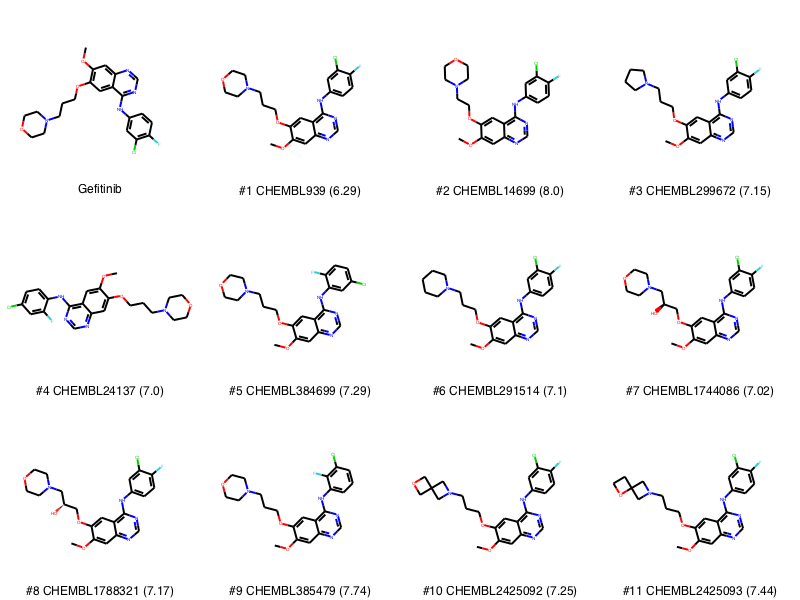

In [37]:
# クエリ構造とトップランクの化合物群（＋生理活性）の描画
sim_mols = [Chem.MolFromSmiles(i) for i in similarity_df.smiles][:11]

legend = ['#' + str(a) + ' ' + b + ' ('+str(round(c,2))+')' for a, b, c in zip(range(1,len(sim_mols)+1),
                                                                               similarity_df.ChEMBL_ID, 
                                                                               similarity_df.bioactivity)]
Chem.Draw.MolsToGridImage(mols = [query] + sim_mols[:11], 
                          legends = (['Gefitinib'] + legend), 
                          molsPerRow = 4)

データセットにおいてゲフィチニブと比較してトップにランクした化合物群は、最初は我々のデータセットに含まれるゲフィチニブのエントリー（rank1　と rank2）で、続いてゲフィチニブの変換体（例　benzole置換基パターンが異なるもの）です。

注：ChEMBLにはゲフィチニブ（よく研究された化合物なので）の完全な構造活性相関分析がふくまれていて、したがって私たちが取得したデータセットにゲフィチニブ様化合物が多く含まれていることは驚くべきことではありません。

それでは、類似度検索がどの程度、データセット上の活性化合物と不活性化合物を区別することができるか、その性能をチェックしたいと思います。そこで、**トークトリアル1**　でChEMBLから取得した化合物の（EGFRに対する）生理活性の値を使用します。

#### エンリッチメントプロットの生成

バーチャルスクリーニングの妥当性を評価し、見つかった活性化合物の比率を見るためにエンリッチメントプロットを作成します。

エンリッチメントプロットが示すのは；
* データセット全体のうち、トップにランクした化合物の比率（x-axis）　 vs. 
* データセット全体のうち活性化合物（y-axis)の比率

MACCSフィンガープリントとMorganフィンガープリントのタニモト類似度を比較します。

化合物を活性化合物あるいは不活性化合物のいずれとして取り扱うかを決めるために、一般に使用されるpIC50のカットオフ値6.3を適用します。文献中にはpIC50カットオフ値として5〜7にわたる範囲でいくつか提案がなされていて、データポイントをとらない排除範囲を定義しているものもありますが、私たちはこのカットオフ（6.3）は合理的と考えています。
同じカットオフを**トークトリアル10**の機械学習でも用います。

In [38]:
# 活性化合物と不活性化合物を区別するpIC50　カットオフ値
threshold = 6.3

In [39]:
similarity_df.head()

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles
2563,CHEMBL939,6.288193,1.000000,1.000000,1.000000,1.000000,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
877,CHEMBL14699,8.000000,1.000000,0.923913,1.000000,0.960452,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CCOCC1
1693,CHEMBL299672,7.148742,0.919355,0.843750,0.957983,0.915254,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCCC1
1867,CHEMBL24137,7.000000,1.000000,0.836735,1.000000,0.911111,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCOCC1
1544,CHEMBL384699,7.292430,1.000000,0.836735,1.000000,0.911111,COc1cc2ncnc(Nc3cc(Cl)ccc3F)c2cc1OCCCN1CCOCC1


In [40]:
def get_enrichment_data(similarity_df, similarity_measure, threshold):
    """
    エンリッチメントプロットのxとyの値を計算する関数：
    x - データセットで何%にランクしているか
    y - 何%の本当に活性な化合物が見つかったか
    """
    
    # データセットの化合物の数を取得
    mols_all = len(similarity_df)
    
    # データセットの活性化合物の数を取得
    actives_all = sum(similarity_df.bioactivity >= threshold)

    # データセット全体を処理している間、活性化合物のカウンターを保持するリストを初期化
    actives_counter_list = []
    
    # 活性化合物のカウンターを初期化
    actives_counter = 0
    
    # 注: エンリッチメントプロットのためデータをランク付けしなければなりません。
    # 選択した類似度評価によって化合物を並べ替えます。
    similarity_df.sort_values([similarity_measure], ascending=False, inplace=True)

    # ランク付けされたデータセットを一つずつ処理し、（生理活性をチェックすることで）各化合物が活性化合物どうか確認します
    for value in similarity_df.bioactivity:
        if value >= threshold:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # 化合物の数をデータセットのランク何%になるかに変換
    mols_perc_list = [i/mols_all for i in list(range(1, mols_all+1))]

    # 活性化合物の数を本当の活性化合物の何％が見つかったかに変換
    actives_perc_list = [i/actives_all for i in actives_counter_list]

    # xとyの値とラベルをもつデータフレームを生成
    enrich_df = pd.DataFrame({'% ranked dataset':mols_perc_list, 
                              '% true actives identified':actives_perc_list,
                              'similarity_measure': similarity_measure})
    
    return enrich_df

In [41]:
# プロットする類似度評価を定義
sim_measures = ['tanimoto_MACCS', 'tanimoto_morgan']

# 全類似度評価についてエンリッチメントプロットのデータを持つデータフレームのリストを作成
enrich_data = [get_enrichment_data(similarity_df, i, threshold) for i in sim_measures]

In [43]:
# プロットのためのデータセットを準備：
# 類似度評価毎のデータフレームを一つのデータフレームに連結
# …異なる類似度評価は「similarity_measure」列によって区別可能です
enrich_df = pd.concat(enrich_data)

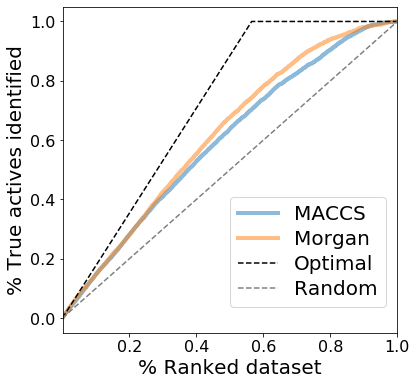

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

for key, grp in enrich_df.groupby(['similarity_measure']):
    ax = grp.plot(ax = ax,
                  x = '% ranked dataset',
                  y = '% true actives identified',
                  label=key,
                  alpha=0.5, linewidth=4)
ax.set_ylabel('% True actives identified', size=fontsize)
ax.set_xlabel('% Ranked dataset', size=fontsize)

# データセットの活性化合物比率
ratio = sum(similarity_df.bioactivity >= threshold) / len(similarity_df)

# 理想的な場合のカーブをプロット
ax.plot([0,ratio,1], [0,1,1], label="Optimal curve", color="black", linestyle="--")

# ランダムな場合のカーブをプロット
ax.plot([0,1], [0,1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(labels=['MACCS', 'Morgan', "Optimal", "Random"], loc=(.5, 0.08), 
           fontsize=fontsize, labelspacing=0.3)

# プロットを保存ーテキストボックスを含めるためにbbox_inchesを使用：
# https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
plt.savefig("../data/T4/enrichment_plot.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

エンリッチメントプロットによるとMACCSフィンガープリントよりもMorganフィンガープリント基づく比較の方が少し良いパフォーマンスを示しています。

In [45]:
# ランク付されたデータセットのx%についてEFを取得
def print_data_ef(perc_ranked_dataset, enrich_df):
    data_ef = enrich_df[enrich_df['% ranked dataset'] <= perc_ranked_dataset].tail(1)
    data_ef = round(float(data_ef['% true actives identified']), 1)
    print("Experimental EF for ", perc_ranked_dataset, "% of ranked dataset: ", data_ef, "%", sep="")

# ランク付されたデータセットのx%についてランダムEFを取得
def print_random_ef(perc_ranked_dataset):
    random_ef = round(float(perc_ranked_dataset), 1)
    print("Random EF for ", perc_ranked_dataset, "% of ranked dataset:       ", random_ef, "%", sep="")

# ランク付されたデータセットのx%について理想的な場合のEFを取得
def print_optimal_ef(perc_ranked_dataset, similarity_df, threshold):
    ratio = sum(similarity_df.bioactivity >= threshold) / len(similarity_df) * 100
    if perc_ranked_dataset <= ratio:
        optimal_ef = round(100/ratio * perc_ranked_dataset, 1)
    else:
        optimal_ef = round(float(100), 2)
    print("Optimal EF for ", perc_ranked_dataset, "% of ranked dataset:      ", optimal_ef, "%", sep="")

In [46]:
# パーセンテージを選択
perc_ranked_list = 5

# EFデータを取得
print_data_ef(perc_ranked_list, enrich_df)
print_random_ef(perc_ranked_list)
print_optimal_ef(perc_ranked_list, similarity_df, threshold)

Experimental EF for 5% of ranked dataset: 1.0%
Random EF for 5% of ranked dataset:       5.0%
Optimal EF for 5% of ranked dataset:      8.9%


**訳注(04/2020)**

オリジナルの実践編はここまでですが、このEFの結果は少しおかしい気がします。エンリッチメントプロットを見ると、エンリッチメントファクターは「**optimal** > **Experimental** > **Random**」となると思われます。**Random**よりも**Experimental**が低いということは、むしろ不活性化合物へと選択のバイアスがかかっていることになってしまいます。

どこかおかしいところがないか？順番に見ていきます。  

まずEFの算出に使われているDataFrame **enrich_df**は２つの類似度評価基準のデータを繋げたものなので、それぞれ別々にしてみます。

In [65]:
# tanimoto_MACCS
enrich_df_taMA = enrich_df[enrich_df['similarity_measure'] == 'tanimoto_MACCS']

# tanimoto_morgan
enrich_df_tamo = enrich_df[enrich_df['similarity_measure'] == 'tanimoto_morgan']

print("Size of enrich_df: ", len(enrich_df))
print("Size of tanimoto_MACCS DataFrame: ", len(enrich_df_taMA))
print("Size of tanimoto_morgan DataFrame: ", len(enrich_df_tamo))

Size of enrich_df:  9046
Size of tanimoto_MACCS DataFrame:  4523
Size of tanimoto_morgan DataFrame:  4523


DataFrameの5% ranked Datasetに相当する箇所を見てみます。

In [82]:
# 5% に相当する数
index_5perc = round(len(enrich_df_taMA)*0.05)

# DataFrameのindexは0から始まるので-1した行を表示
enrich_df_taMA[index_5perc-1:index_5perc]

,% ranked dataset,% true actives identified,similarity_measure
225,0.049967,0.07319,tanimoto_MACCS


見やすさのためsliceでDataFrameとして取り出しています。  
ランク上位5%(0.049)に相当する数のなかに、実際の活性評価でactiveだったものは7.3%(% true actives identified, 0.07319)となっています。この値は先の**Random**、**Optimal**と比較して妥当な値に思います。

DataFrameのデータ自体には問題なさそうなので、値の取り出し方（関数`print_data_ef`）に問題があったのでしょう。
関数の中身を順番に実行してみます。 

In [83]:
# 5%に設定
perc_ranked_dataset = 5

# 5%内のDataFrameを取り出し、その一番最後の行(tail)を取り出す
enrich_df[enrich_df['% ranked dataset'] <= perc_ranked_dataset].tail(1)

,% ranked dataset,% true actives identified,similarity_measure
4522,1.0,1.0,tanimoto_morgan


取り出されたのは「index:4522」で4523番目の行です。この`% true actives identifed`列がEFとして取り出されていた値(1.0)です。  
閾値5以下で取り出されたのは`similarity_measure`:**tanimoto_morgan**の全化合物でした。単純にDataFrameのデータは%に換算していないのに、取り出す際に%換算の値を使ってしまったのが原因のようです。  

それではそれぞれの類似度について正しい値を確認してみます。

In [92]:
# 関数の再定義
def print_data_ef2(perc_ranked_dataset, enrich_df):
    perc_ranked_dataset_100 = perc_ranked_dataset / 100
    data_ef = enrich_df[enrich_df['% ranked dataset'] <= perc_ranked_dataset_100].tail(1)
    data_ef = round(float(data_ef['% true actives identified'] * 100), 1)
    print("Experimental EF for ", perc_ranked_dataset, "% of ranked dataset: ", data_ef, "%", sep="")

In [93]:
# MACCS keyの場合
# パーセンテージを選択
perc_ranked_list = 5

# EFデータを取得
print_data_ef2(perc_ranked_list, enrich_df_taMA)
print_random_ef(perc_ranked_list)
print_optimal_ef(perc_ranked_list, similarity_df, threshold)

Experimental EF for 5% of ranked dataset: 7.3%
Random EF for 5% of ranked dataset:       5.0%
Optimal EF for 5% of ranked dataset:      8.9%


In [94]:
# Morganフィンガープリントの場合
# パーセンテージを選択
perc_ranked_list = 5

# EFデータを取得
print_data_ef2(perc_ranked_list, enrich_df_tamo)
print_random_ef(perc_ranked_list)
print_optimal_ef(perc_ranked_list, similarity_df, threshold)

Experimental EF for 5% of ranked dataset: 7.9%
Random EF for 5% of ranked dataset:       5.0%
Optimal EF for 5% of ranked dataset:      8.9%


いずれも「**optimal** > **Experimental** > **Random**」となっており、**Morgan**の方が**MACCS**よりも若干良い値となっています。無事エンリッチメントプロットと比較してもおかしくない値が得られました。

**訳注ここまで**

## ディスカッション

ここではタニモト類似度を使ってバーチャルスクリーニングを実施しました。もちろん、Dice類似度や他の類似度評価を使っても行うことができます。

化合物フィンガープリントを使用した類似度検索の欠点は、化合物類似度に基づくものなので新規な構造を生み出さないことです。化合物類似度を扱う上でのその他の課題としては、いわゆるアクティビティクリフ（activity cllif）があります。分子の官能基におけるちょっとした変化が生理活性の大きな変化を起こすことがあります。

## クイズ

* アクティビティクリフを回避するにはどこから始めれば良いでしょうか？
* MACCSフィンガープリントとMorganフィンガープリントを互いに比較した場合の利点と欠点は何でしょう？
* 使用したフィンガープリントによっておこる、類似度データフレームにおける順序の違いをどう説明できるでしょうか？